In [37]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

/var/folders/3r/1_4kntk961qgw8h34vb14_8h0000gn/T/ipykernel_24490/2854789959.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [27]:
df = pd.read_excel('tsla_1min.xlsx', usecols=['Local Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.rename(columns={'Local Date': 'Date'}, inplace=True)
df.sort_values('Date', inplace=True)
df.fillna(method='ffill', inplace=True)
df.head(5)

,Date,Close,Open,Low,High,Volume
43199,2022-05-11 10:01:00,812.84,813.04,803.04,814.00,3550.0
43198,2022-05-11 10:02:00,811.51,812.79,811.51,813.00,2877.0
43197,2022-05-11 10:03:00,812.60,811.89,810.36,812.60,3791.0
43196,2022-05-11 10:04:00,809.60,812.36,809.17,813.00,1491.0
43195,2022-05-11 10:05:00,808.90,808.88,808.33,809.71,654.0


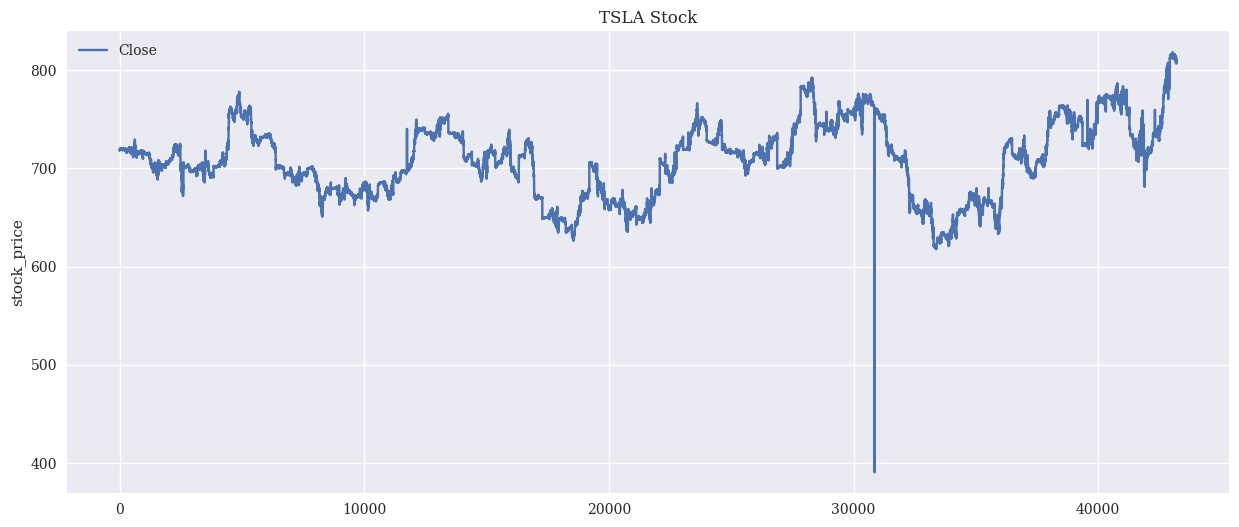

In [28]:
df[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("TSLA Stock")
plt.show()

In [29]:
X = df[['Open', 'Low', 'High', 'Volume']]
y = df['Close']

In [30]:
X.head(5)

,Open,Low,High,Volume
43199,813.04,803.04,814.00,3550.0
43198,812.79,811.51,813.00,2877.0
43197,811.89,810.36,812.60,3791.0
43196,812.36,809.17,813.00,1491.0
43195,808.88,808.33,809.71,654.0


In [106]:
# Splitting data into training and test sets initially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = ['Open', 'Low', 'High', 'Volume']

numeric_transformer = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Applying transformations separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [107]:
X_train_transformed

array([[ 2.60726237,  2.37568637,  2.6049445 , -0.49665155],
       [ 2.60104582,  2.5859954 ,  2.58013379, -0.5078221 ],
       [ 2.57866622,  2.55744105,  2.57020951, -0.4926514 ],
       ...,
       [-0.71735122, -0.70421128, -0.73482479, -0.5283042 ],
       [-0.71884319, -0.70421128, -0.72961454, -0.52320857],
       [-0.71610791, -0.69527252, -0.72018647, -0.51695107]])

In [108]:
# Recreate DataFrames with feature names for interpretability
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numeric_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features, index=X_test.index)

In [109]:
X_train_transformed_df

,Open,Low,High,Volume
43199,2.607262,2.375686,2.604944,-0.496652
43198,2.601046,2.585995,2.580134,-0.507822
43197,2.578666,2.557441,2.570210,-0.492651
43196,2.590353,2.527893,2.580134,-0.530827
43195,2.503819,2.507036,2.498507,-0.544720
...,...,...,...,...
8644,-0.715859,-0.696514,-0.732096,-0.549317
8643,-0.714616,-0.697011,-0.732096,-0.551940
8642,-0.717351,-0.704211,-0.734825,-0.528304
8641,-0.718843,-0.704211,-0.729615,-0.523209


In [110]:
print('x_train.shape = ',X_train_transformed_df.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test_transformed_df.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (34560, 4)
y_train.shape =  (34560,)
x_test.shape =  (8640, 4)
y_test.shape =  (8640,)


In [111]:
X_train_tensor = torch.tensor(X_train_transformed_df.values.astype(float)).float().unsqueeze(1)
X_test_tensor = torch.tensor(X_test_transformed_df.values.astype(float)).float().unsqueeze(1)

y_train_tensor = torch.tensor(y_train.values.astype(float)).float()
y_test_tensor = torch.tensor(y_test.values.astype(float)).float()

In [112]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0) # Extract batch size from input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) # Select the output of the last time step
        
        return out


In [102]:
X_train_transformed_df.shape[1]

4

In [115]:
net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],  # Number of features
    module__hidden_size=32,
    module__num_layers=2,
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    batch_size=32,
    max_epochs=100,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

net.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   469960.5192   508899.2559  1.2108
      2   435261.0103   477052.5655  1.0232
      3   406675.0954   447606.2969  0.9978
      4   379804.1309   419566.8326  1.0555
      5   354154.3875   392655.5826  1.0038
      6   329557.0158   366760.0314  0.9951
      7   305939.1745   341828.6335  0.9872
      8   283266.7533   317837.2266  0.9870
      9   261522.9252   294773.1256  0.9877
     10   240698.7777   272629.6001  1.0260
     11   220788.7682   251402.5348  1.0699
     12   201789.7038   231089.6903  1.0015
     13   183698.2487   211687.5415  0.9944
     14   166511.2561   193193.4267  0.9813
     15   150225.4943   175604.8970  0.9803
     16   134838.0751   158919.8096  0.9905
     17   120345.6484   143134.5727  1.0029
     18   106743.8556   128245.7657  1.0232
     19    94028.5015   114250.2664  1.0130
     20    82194.5578   101143.4579  1.0167
     21    71236.6132    88920.6

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTM(
    (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
    (fc): Linear(in_features=32, out_features=1, bias=True)
  ),
)

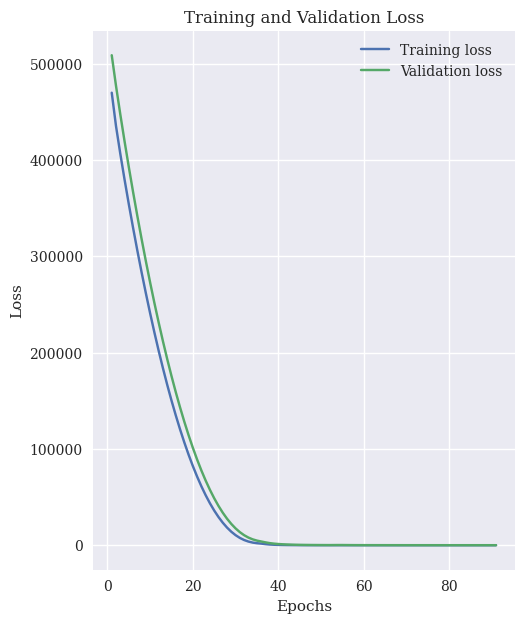

In [116]:
# Access training history
history = net.history_

# Extract training and validation loss
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

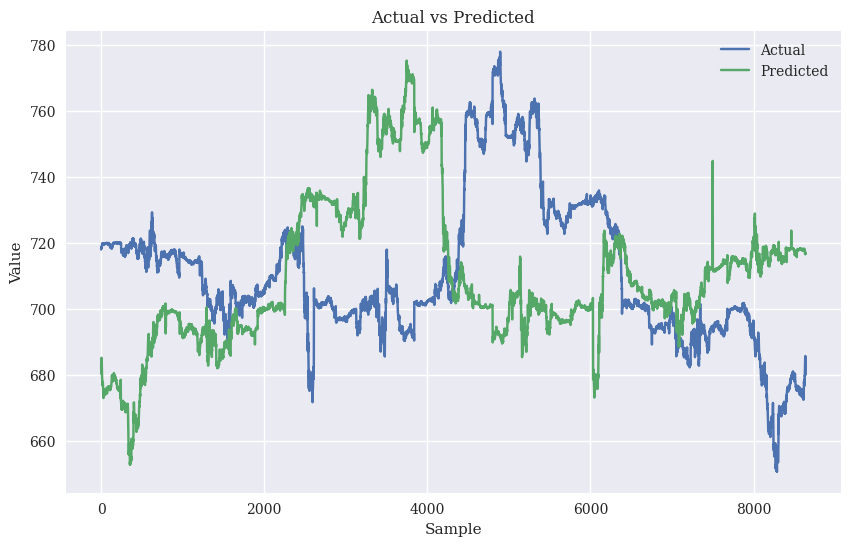

In [124]:
# Obtain predictions on the test set
y_pred = net.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [126]:
# Predictions on the training set
y_train_pred = net.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 16.07821442378272
Mean Squared Error (MSE) - Test Set: 2.2740392872022293
